In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import numpy as np
from sklearn.utils import shuffle
import pandas as pd

import h5py
import os
import shutil

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import numpy as np
from tqdm import tqdm
import cv2

np.random.seed(2017)

n = 24962
X = np.zeros((n, 299, 299, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

train_cat2 = os.listdir("train2/cat")
train_dog2 = os.listdir("train2/dog")

i = 0
for filename in train_cat2:
    X[i] = cv2.resize(cv2.imread('train/%s' % filename), (299, 299))
    y[i] = 0
    i += 1
for filename in train_dog2:
    X[i] = cv2.resize(cv2.imread('train/%s' % filename), (299, 299))
    y[i] = 1
    i += 1

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## 模型一

In [68]:
base_model = Xception(input_tensor=Lambda(xception.preprocess_input)(Input((299, 299, 3))), weights='imagenet',include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [73]:
model.load_weights('xception_weights_1.h5')

In [74]:
cnn_model = Model(model.input, model.layers[-4].output, name='Xception')

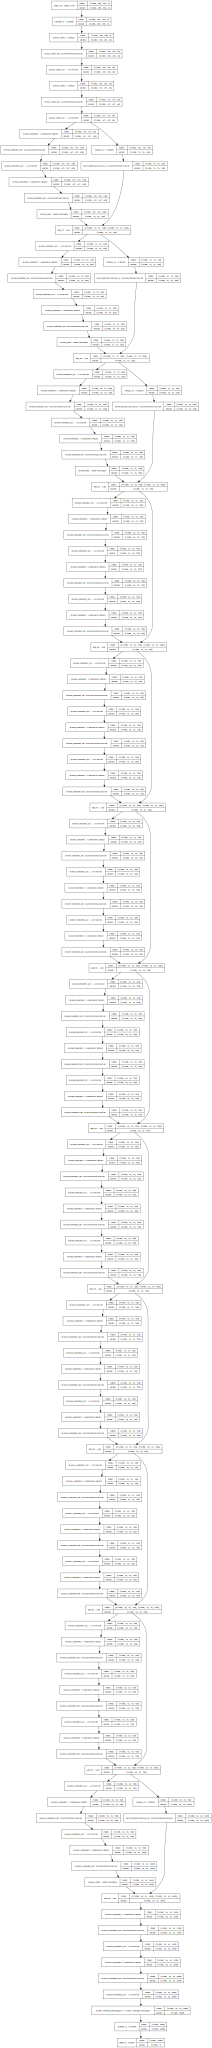

In [75]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [77]:
inputs = Input((299, 299, 3))
x = inputs
x = cnn_model(x)
cam = Conv2D(1, 1, use_bias=False, name='cam')(x)
model_cam = Model(inputs, cam)

In [86]:
weights = model.get_weights()[-3]

In [78]:
model_cam.layers[-1].set_weights([weights.reshape((1, 1, 2048, 1))])

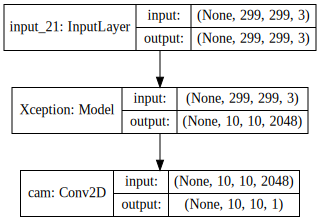

In [80]:
SVG(model_to_dot(model_cam, show_shapes=True).create(prog='dot', format='svg'))

prediction: [[0.99760973]]


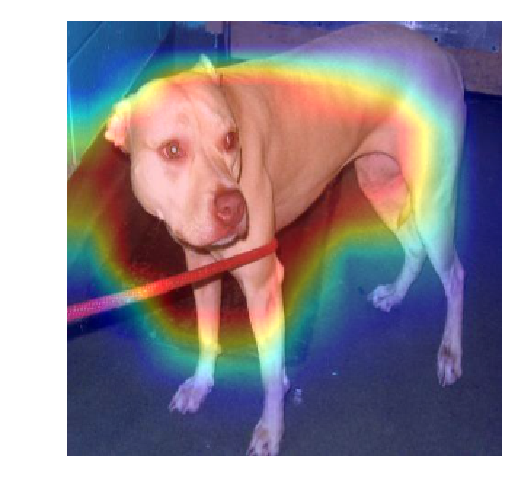

In [84]:
import  matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 用模型进行预测
index = 13734
img = X[index]
prediction = model.predict(np.expand_dims(img, 0))
print("prediction:", prediction)
prediction = prediction[0, 0]

cam = model_cam.predict(np.expand_dims(img, 0))
cam = cam[0, :, :, 1 if prediction < 0.5 else 0]

# 调整 CAM 的范围
cam /= 10
cam[cam < 0] = 0
cam[cam > 1] = 1
cam = cv2.resize(cam, (299, 299))
cam = np.uint8(255*cam)

# 染成彩色
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

# 加在原图上
out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

# 显示图片
plt.axis('off')
plt.imshow(out[:,:,::-1])

# 模型二

In [85]:
model.load_weights('xception_weights_2.h5')

In [87]:
model_cam.layers[-1].set_weights([weights.reshape((1, 1, 2048, 1))])

prediction: [[1.]]


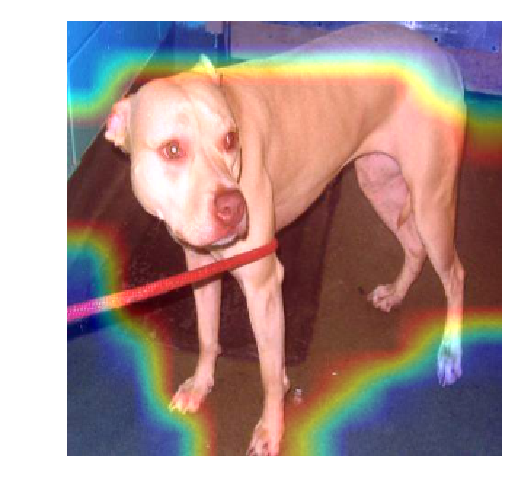

In [96]:
# 用模型进行预测
index = 13734
img = X[index]
prediction = model.predict(np.expand_dims(img, 0))
print("prediction:", prediction)
prediction = prediction[0, 0]

cam = model_cam.predict(np.expand_dims(img, 0))
cam = cam[0, :, :, 1 if prediction < 0.5 else 0]

# 调整 CAM 的范围
cam /= 10
cam[cam < 0] = 0
cam[cam > 1] = 1
cam = cv2.resize(cam, (299, 299))
cam = np.uint8(255*cam)

# 染成彩色
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

# 加在原图上
out = cv2.addWeighted(img, 1, heatmap, 0.4, 0)

# 显示图片
plt.axis('off')
plt.imshow(out[:,:,::-1])

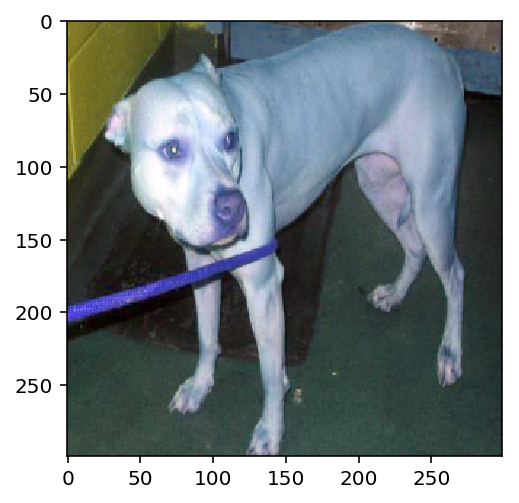

In [91]:
plt.imshow(img)